# 🍽️ GourmetAI – Food Image Classification Optimization

Welcome to the repository for the **optimization of a food image classification neural network** developed for **GourmetAI Inc.**, a leading company in food tech innovation. This project focuses on boosting the **accuracy**, **efficiency**, and **generalization** of a deep learning model designed to recognize and categorize food images.

## 🚀 Project Overview

GourmetAI is tackling the challenge of improving food image recognition systems to better serve its customers and streamline operations. Using advanced deep learning strategies, we aim to build a robust model that delivers fast and reliable classification results.

### 💡 Why It Matters

- **Better User Experience**: High-accuracy predictions enhance apps and services for end-users.
- **Operational Efficiency**: Automated classification reduces manual intervention and processing time.
- **Tech Leadership**: Cutting-edge solutions solidify GourmetAI’s position as a market innovator.

## 🧠 Techniques Used

- **Data Augmentation**: Applied a variety of image augmentation strategies (e.g., rotation, flipping, color jitter) to increase dataset diversity and reduce overfitting.
- **Transfer Learning**: Leveraged pre-trained CNN architectures to accelerate training and improve baseline accuracy.
- **Fine Tuning**: Carefully tuned the final classifier layers and selectively unfroze parts of the backbone to adapt the model to the food domain.
- **Regularization**: Included dropout, early stopping, and weight decay to mitigate overfitting.
- **Validation Strategies**: Employed validation sets and K-fold cross-validation (when needed) for better hyperparameter tuning and performance estimation.

## 🧪 Project Pipeline

1. **Data Preparation**
   - Splitting into training, validation, and test sets.
   - Applying augmentations to training data only.
2. **Model Selection**
   - Choosing architecture(s) based on performance tradeoffs.
   - Initial benchmarking with frozen weights.
3. **Training & Optimization**
   - Fine-tuning with selected hyperparameters.
   - Iterative validation and model adjustments.
4. **Evaluation**
   - Final test set evaluation.
   - Reporting accuracy, precision, recall, and confusion matrices.

## ⚙️ Challenges

- **Dataset Imbalance**: Addressed with weighted loss functions and targeted augmentations.
- **Overfitting**: Managed via regularization techniques and careful validation.
- **Model Generalization**: Ensured through rigorous testing on unseen data.

## 📈 Outcomes & Benefits

The optimized model demonstrates strong generalization performance and faster inference times, contributing directly to improved user satisfaction and business process automation.

---


For questions or contributions, open an issue or submit a pull request.

**GourmetAI Inc.** – Empowering food tech through deep learning.



In [ ]:
#Download and unzip data from aws repository of ProfessionAI.

!wget https://proai-datasets.s3.eu-west-3.amazonaws.com/dataset_food_classification.zip
!unzip dataset_food_classification.zip

Output streaming troncato alle ultime 5000 righe.
  inflating: dataset/train/omelette/582339_43563ec9bb144f60866003fdde13591d.jpg  
  inflating: dataset/train/omelette/582525_1d6397f338bd4c7ab1b86b4d6414f0f7.jpg  
  inflating: dataset/train/omelette/2930618_18106524b6f64adf805c732176c000ea.jpg  
  inflating: dataset/train/omelette/84313_32b6136cb7bd47e58805b580b781cb17.jpg  
  inflating: dataset/train/omelette/3415929_7c4dd9417da141ecbee09381d142d3d1.jpg  
  inflating: dataset/train/omelette/2081062_eb523a3ad4b9470fb598dcf785b73063.jpg  
  inflating: dataset/train/omelette/1938551_b908c7a56ece460f812bc5bad143d14e.jpg  
  inflating: dataset/train/omelette/993789_3bba73a90dbf42af84d04a27faddb284.jpg  
  inflating: dataset/train/omelette/1063810_e8b94da9e961441b89b25d25dca9c600.jpg  
  inflating: dataset/train/omelette/1825409_613c50e92f9f421d9ad1ba210a8b72db.jpg  
  inflating: dataset/train/omelette/2609473_177eb3c969ec4ed0853690ee59e81863.jpg  
  inflating: dataset/train/omelette/236773

In [ ]:
#Load libraries
#Pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from torchsummary import summary
# Libraries for Augmentation and preprocessing of images
import torchvision
from torchvision.transforms import ToTensor, Compose
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Dataviz
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# Other
import os
from PIL import Image
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import random
import json


In [ ]:
# Ignore Warning
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


##Data Explorarion

Before diving into any modeling, let’s start by exploring the data we have. The dataset is organized into three folders: *train*, *val*, and *test*. We'll use a function to load each of them and extract some basic information, like dataset size and sample images.

In [ ]:
class Transforms:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, *args, **kwargs):
        return self.transforms(image=np.array(img))['image']

In [ ]:
transform = A.Compose([
            A.Resize(256, 256),
            A.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ToTensorV2(),
        ])


In [ ]:
trainset = torchvision.datasets.ImageFolder(root='dataset/train', transform=Transforms(transform))

valset = torchvision.datasets.ImageFolder(root='dataset/val', transform=Transforms(transform))

testset = torchvision.datasets.ImageFolder(root='dataset/test',transform=Transforms(transform))

In [ ]:
# Number of images
print(f"There are {len(trainset)} images for training")
print(f"There are {len(valset)} images for validation")
print(f"There are {len(testset)} images for testing")

There are 8960 images for training
There are 2240 images for validation
There are 2800 images for testing


In [ ]:
# Number of classes
print(f"There are {len(trainset.classes)} classes for training")
print(f"There are {len(valset.classes)} classes for validation")
print(f"There are {len(testset.classes)} classes for testing")

There are 14 classes for training
There are 14 classes for validation
There are 14 classes for testing


In [ ]:
# Creae a function to print number of element for each classes
def CountClassElements(dataset):
    class_counts = Counter([label for _, label in dataset])
    class_names = dataset.classes

    for class_idx, count in class_counts.items():
        print(f"{class_names[class_idx]}: {count} images")
    class_count_dict = {class_names[idx]: count for idx, count in class_counts.items()}

    # Plot
    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(class_count_dict.keys()), y=list(class_count_dict.values()), palette="magma")
    plt.title("Class Distribution")
    plt.ylabel("Number of images")
    plt.xlabel("Classes")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

Baked Potato: 640 images
Crispy Chicken: 640 images
Donut: 640 images
Fries: 640 images
Hot Dog: 640 images
Sandwich: 640 images
Taco: 640 images
Taquito: 640 images
apple_pie: 640 images
cheesecake: 640 images
chicken_curry: 640 images
ice_cream: 640 images
omelette: 640 images
sushi: 640 images


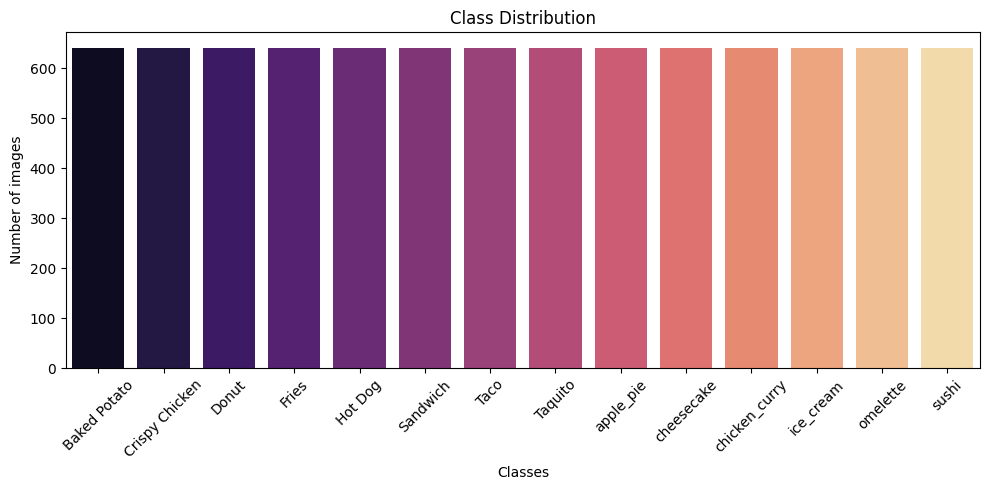

In [ ]:
CountClassElements(trainset)

Baked Potato: 200 images
Crispy Chicken: 200 images
Donut: 200 images
Fries: 200 images
Hot Dog: 200 images
Sandwich: 200 images
Taco: 200 images
Taquito: 200 images
apple_pie: 200 images
cheesecake: 200 images
chicken_curry: 200 images
ice_cream: 200 images
omelette: 200 images
sushi: 200 images


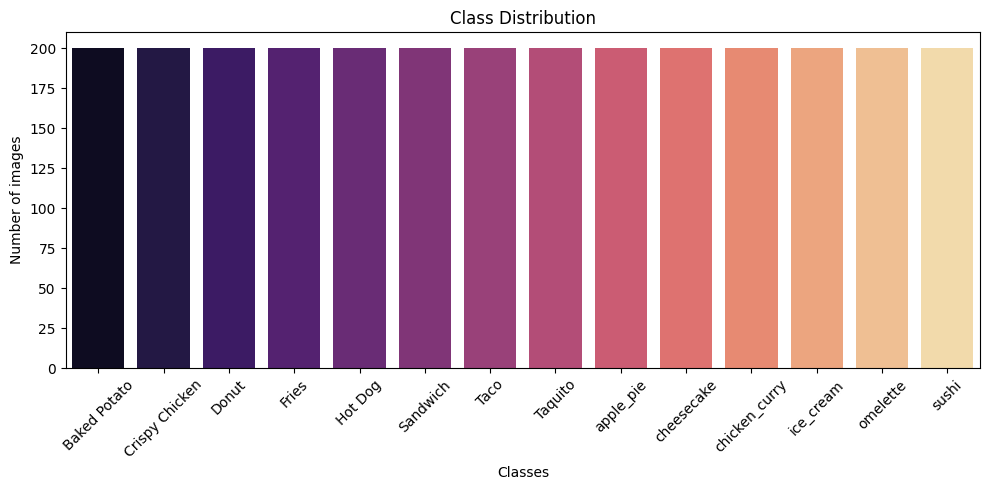

In [ ]:
CountClassElements(testset)

Baked Potato: 160 images
Crispy Chicken: 160 images
Donut: 160 images
Fries: 160 images
Hot Dog: 160 images
Sandwich: 160 images
Taco: 160 images
Taquito: 160 images
apple_pie: 160 images
cheesecake: 160 images
chicken_curry: 160 images
ice_cream: 160 images
omelette: 160 images
sushi: 160 images


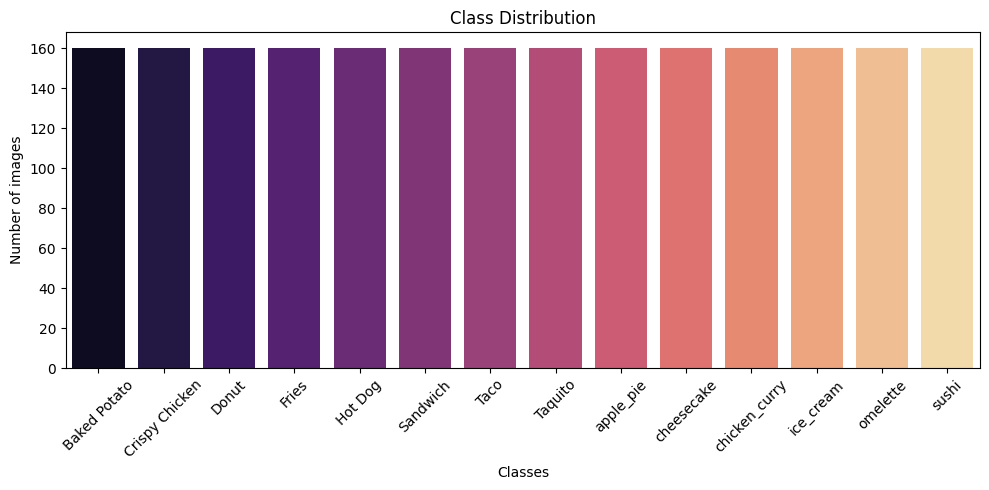

In [ ]:
CountClassElements(valset)

The three datasets are balanced, with an equal number of images per class. Let's visualize some random samples from each dataset.

In [ ]:
# Function to convert from tensor to image
def back_to_image(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    return np.transpose(npimg, (1, 2, 0))


#### Select random images and display them
def show_random_images(dataset, num_images=5):
    """
      dataset : torch dataset
      num_images : number of images to select and show
    """
    indices = random.sample(range(len(dataset)), num_images)
    plt.figure(figsize=(15, 10))
    for i, idx in enumerate(indices):
        img, label = dataset[idx]
        ax = plt.subplot(1, num_images, i+1)
        ax.imshow(back_to_image(img))
        ax.set_title(f"Label: {dataset.classes[label]}")
        ax.axis('off')
    plt.show()

_________Training images_________


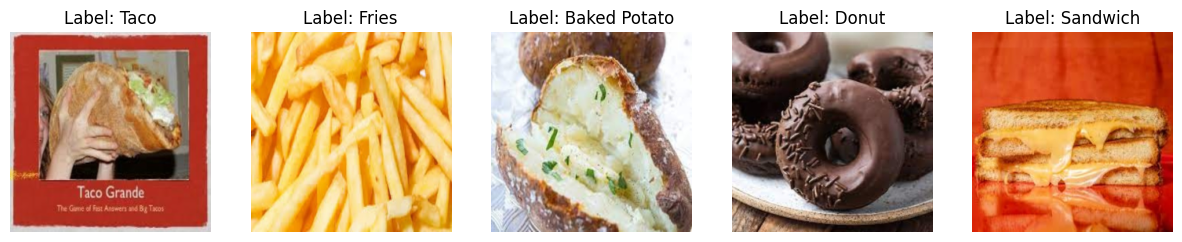

_________Validation images_________


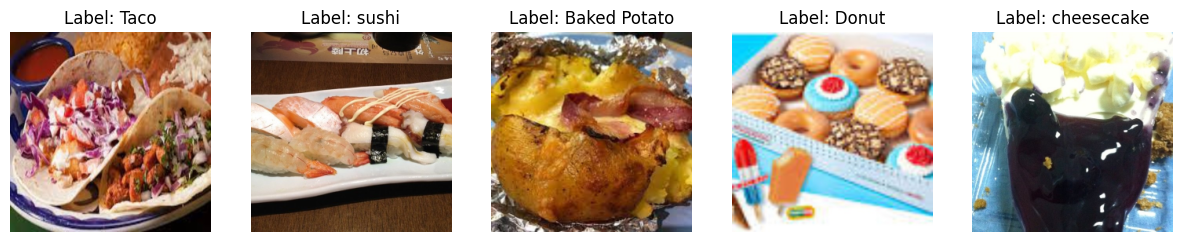

_________Test images_________


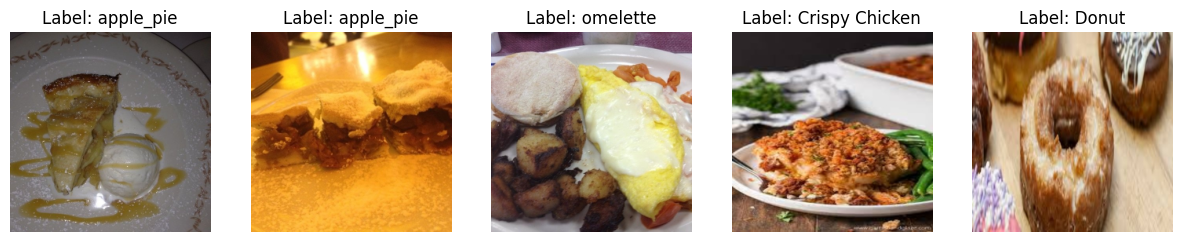

In [ ]:
print("_________Training images_________")
show_random_images(trainset)

print("_________Validation images_________")
show_random_images(valset)

print("_________Test images_________")
show_random_images(testset)

## Training preparation
We now define the core utility functions that will support the training process, including early stopping to prevent overfitting and preserve generalization. These components will help us monitor performance and make the training more efficient and robust. We will use only training and validation sets.



In [ ]:
# Early Stopping
class EarlyStopping:
    def __init__(self, save_path, patience=5, min_delta=0):

        self.save_path = save_path
        self.patience = patience
        self.min_delta = min_delta
        self.min_val_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, validation_loss, model):

        if self.min_val_loss is None:     #Prima epoca
          self.min_val_loss = validation_loss
          self.save_checkpoint(model)

        elif (self.min_val_loss - validation_loss) > self.min_delta: #Epoca con miglioramento
          self.min_val_loss = validation_loss
          self.save_checkpoint(model)
          self.counter = 0


        else:     #Nessun miglioramento
          self.counter +=1
          if self.counter >= self.patience:
            self.early_stop = True

    def save_checkpoint(self, model):
      torch.save(model.state_dict(), self.save_path)

In [ ]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    processed_data = 0

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        processed_data += len(inputs)

    return running_loss / processed_data

In [ ]:
def test_epoch(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for i, data in enumerate(test_loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    return running_loss / total, correct / total

In [ ]:
def train(model, train_loader, test_loader, criterion, optimizer, device, epochs=100, early_stopping=None):
    train_losses = []
    test_losses = []
    test_accuracies = []

    for epoch in range(epochs):
        train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
        test_loss, test_accuracy = test_epoch(model, test_loader, criterion, device)

        train_losses.append(train_loss)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {test_loss:.4f}, Validation Accuracy: {test_accuracy:.4f}')

        if early_stopping is not None:
            early_stopping(test_loss, model)
            if early_stopping.early_stop:
                print("Early stopping")
                break

    return train_losses, test_losses, test_accuracies

In [ ]:
## Confusion Matrix to visualize the results
def plot_confusion_matrix(model, test_loader, device):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for i, data in enumerate(test_loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)

            outputs = model(inputs)

            _, predicted = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')

### Transfer Learning


We download some models for transfer learning. First we'll try with VGG16. We will change only the last layer to adapt the model to our problem.


In [ ]:
from torchvision.models import vgg16, VGG16_Weights
vgg_base = vgg16(weights = VGG16_Weights.IMAGENET1K_V1).to(device)
summary(vgg_base, (3,256,256))

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 238MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
              ReLU-2         [-1, 64, 256, 256]               0
            Conv2d-3         [-1, 64, 256, 256]          36,928
              ReLU-4         [-1, 64, 256, 256]               0
         MaxPool2d-5         [-1, 64, 128, 128]               0
            Conv2d-6        [-1, 128, 128, 128]          73,856
              ReLU-7        [-1, 128, 128, 128]               0
            Conv2d-8        [-1, 128, 128, 128]         147,584
              ReLU-9        [-1, 128, 128, 128]               0
        MaxPool2d-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]         295,168
             ReLU-12          [-1, 256, 64, 64]               0
           Conv2d-13          [-1, 256, 64, 64]         590,080
             ReLU-14          [-1, 256,

In [ ]:
#Freeze parameters
for param in vgg_base.parameters():
    param.requires_grad = False

In [ ]:
# Model with DropOut and GELU
class VGGClassifier(nn.Module):
    def __init__(self, vgg_backbone, in_features, num_classes, dropout_p=0.3):
        super().__init__()
        self.features = vgg_backbone.features
        self.pooling = nn.AdaptiveAvgPool2d((1,1))

        self.classifier = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.GELU(),
            nn.Dropout(p=dropout_p),
            nn.Linear(512, 256),
            nn.GELU(),
            nn.Dropout(p=dropout_p),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.pooling(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [ ]:
vgg = VGGClassifier(vgg_base, 512, 14).to(device)

In [ ]:
vgg_save_folder = "models/vgg/"
os.makedirs(vgg_save_folder, exist_ok = True)
vgg_save_file = os.path.join(vgg_save_folder,"model.pt")
vgg_save_log = os.path.join(vgg_save_folder,"log.json")


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vgg.parameters(), lr=0.001)
early_stopping = EarlyStopping(vgg_save_file, patience=5, min_delta=0)
epochs = 100

In [ ]:
# Check if only last layer is trainable
for name, param in vgg.named_parameters():
    if param.requires_grad:
        print(f"{name} will be updated")

classifier.0.weight will be updated
classifier.0.bias will be updated
classifier.3.weight will be updated
classifier.3.bias will be updated
classifier.6.weight will be updated
classifier.6.bias will be updated


We reload the data to re-normalize it, since VGG16 expects the inputs to be normalized in a specific way.

In [ ]:

transformVGG16 = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

trainsetVGG16 = torchvision.datasets.ImageFolder(root='dataset/train', transform=Transforms(transformVGG16))

valsetVGG16 = torchvision.datasets.ImageFolder(root='dataset/val', transform=Transforms(transformVGG16))

testsetVGG16 = torchvision.datasets.ImageFolder(root='dataset/test',transform=Transforms(transformVGG16))


In [ ]:
#Upload datasets in Data Loader object

batch_size = 128
trainloader = torch.utils.data.DataLoader(trainsetVGG16, batch_size=batch_size,
                                          shuffle=True) # We use shuffle only for Training
valloader = torch.utils.data.DataLoader(valsetVGG16, batch_size=batch_size,
                                          shuffle=False)

testloader = torch.utils.data.DataLoader(testsetVGG16, batch_size=batch_size,
                                         shuffle=False)

#### Hyperparameter Tuning on Subset
Before training the final model, we perform a quick hyperparameter tuning using only a subset of the training dataset (20%). This allows us to efficiently evaluate different combinations of learning rates and optimizers without the high computational cost of full training.
We train each configuration for a few epochs and validate on the validation set to identify the best-performing setup. Once the optimal hyperparameters are found, we use them to train the model on the full dataset.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split, DataLoader
from tqdm import tqdm
import copy

def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    return running_loss / len(dataloader.dataset)

def evaluate(model, dataloader, criterion, device):
    model.eval()
    val_loss = 0.0
    correct = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
    accuracy = correct / len(dataloader.dataset)
    return val_loss / len(dataloader.dataset), accuracy

def tune_hyperparameters(model_class, base_model, train_dataset, val_loader, num_classes, device):
    subset_size = int(0.2 * len(train_dataset))
    train_subset, _ = random_split(train_dataset, [subset_size, len(train_dataset) - subset_size])
    results = []

    hyperparams_grid = [
        {'lr': 1e-3, 'optimizer': 'adam'},
        {'lr': 1e-4, 'optimizer': 'adam'},
        {'lr': 1e-3, 'optimizer': 'sgd'},
        {'lr': 1e-4, 'optimizer': 'sgd'},
    ]

    for config in hyperparams_grid:
        print(f"Testing configuration: {config}")
        model = model_class(copy.deepcopy(base_model), in_features=512, num_classes=num_classes).to(device)
        criterion = nn.CrossEntropyLoss()
        if config['optimizer'] == 'adam':
            optimizer = optim.Adam(model.parameters(), lr=config['lr'], weight_decay=1e-5)
        else:
            optimizer = optim.SGD(model.parameters(), lr=config['lr'], momentum=0.9, weight_decay=1e-5)

        train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)

        best_val_loss = float('inf')
        for epoch in range(5):
            train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
            val_loss, val_acc = evaluate(model, val_loader, criterion, device)
            print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model = copy.deepcopy(model.state_dict())

        results.append((config, best_val_loss))


    best_config = sorted(results, key=lambda x: x[1])[0]
    print(f"Best configuration found: {best_config[0]} with val loss {best_config[1]:.4f}")
    return best_config[0]


In [ ]:
best_hyperparams = tune_hyperparameters(VGGClassifier, vgg_base, trainsetVGG16, valloader, num_classes=14, device=device)

Testing configuration: {'lr': 0.001, 'optimizer': 'adam'}
Epoch 1: Train Loss=1.7831, Val Loss=1.0407, Val Acc=0.6647
Epoch 2: Train Loss=0.9308, Val Loss=0.8614, Val Acc=0.7330
Epoch 3: Train Loss=0.6988, Val Loss=0.8466, Val Acc=0.7295
Epoch 4: Train Loss=0.5565, Val Loss=0.8068, Val Acc=0.7317
Epoch 5: Train Loss=0.4748, Val Loss=0.8279, Val Acc=0.7299
Testing configuration: {'lr': 0.0001, 'optimizer': 'adam'}
Epoch 1: Train Loss=2.5805, Val Loss=2.5108, Val Acc=0.3094
Epoch 2: Train Loss=2.3516, Val Loss=2.1528, Val Acc=0.4527
Epoch 3: Train Loss=1.8450, Val Loss=1.5567, Val Acc=0.6312
Epoch 4: Train Loss=1.4202, Val Loss=1.2841, Val Acc=0.6661
Epoch 5: Train Loss=1.2147, Val Loss=1.1383, Val Acc=0.6777
Testing configuration: {'lr': 0.001, 'optimizer': 'sgd'}
Epoch 1: Train Loss=2.6363, Val Loss=2.6289, Val Acc=0.0991
Epoch 2: Train Loss=2.6194, Val Loss=2.6140, Val Acc=0.1219
Epoch 3: Train Loss=2.6018, Val Loss=2.5978, Val Acc=0.1379
Epoch 4: Train Loss=2.5818, Val Loss=2.5791, V


Even though we trained for only a few epochs and on a subset of the training data, we choose the parameters that seem to have shown better performance


In [ ]:
best_hyperparams

{'lr': 0.001, 'optimizer': 'adam'}

In [ ]:

criterion = nn.CrossEntropyLoss()
# Adam with lr 0.001
optimizer = torch.optim.Adam(vgg.parameters(), lr=best_hyperparams["lr"])
early_stopping = EarlyStopping(vgg_save_file, patience=5, min_delta=0)
epochs = 50



Let's run an initial training with the loaded data, without using data augmentation

In [ ]:
train_losses, test_losses, test_accuracies = train(vgg, trainloader, valloader, criterion, optimizer, device, epochs, early_stopping)

Epoch 1/50, Train Loss: 0.0104, Validation Loss: 0.0062, Validation Accuracy: 0.7589
Epoch 2/50, Train Loss: 0.0057, Validation Loss: 0.0054, Validation Accuracy: 0.7848
Epoch 3/50, Train Loss: 0.0047, Validation Loss: 0.0049, Validation Accuracy: 0.8018
Epoch 4/50, Train Loss: 0.0042, Validation Loss: 0.0050, Validation Accuracy: 0.7982
Epoch 5/50, Train Loss: 0.0037, Validation Loss: 0.0046, Validation Accuracy: 0.8080
Epoch 6/50, Train Loss: 0.0034, Validation Loss: 0.0048, Validation Accuracy: 0.8027
Epoch 7/50, Train Loss: 0.0030, Validation Loss: 0.0047, Validation Accuracy: 0.8067
Epoch 8/50, Train Loss: 0.0029, Validation Loss: 0.0048, Validation Accuracy: 0.8098
Epoch 9/50, Train Loss: 0.0026, Validation Loss: 0.0046, Validation Accuracy: 0.8107
Epoch 10/50, Train Loss: 0.0023, Validation Loss: 0.0049, Validation Accuracy: 0.8071
Epoch 11/50, Train Loss: 0.0021, Validation Loss: 0.0049, Validation Accuracy: 0.8058
Epoch 12/50, Train Loss: 0.0018, Validation Loss: 0.0048, Valid

Let's try now with some data augmentation techniques . We will apply only them to train dataset.

In [ ]:

train_transformVGG16 = A.Compose([
    A.Resize(height=256, width=256),
    A.RandomCrop(height=224, width=224),
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.Perspective(scale=(0.05, 0.1), p=0.3),
    A.CoarseDropout(max_holes=3, max_height=32, max_width=32, p=0.3),
    A.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1, p=0.8),
    A.OneOf([
        A.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.05),
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2),
    ], p=0.8),
    A.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])



trainsetVGG16_aug = torchvision.datasets.ImageFolder(root='dataset/train', transform=Transforms(train_transformVGG16))



In [ ]:
val_transformVGG16 = A.Compose([
    A.Resize(height=224, width=224),
    A.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

valsetVGG16_aug = torchvision.datasets.ImageFolder(root='dataset/val', transform=Transforms(val_transformVGG16))

testsetVGG16_aug = torchvision.datasets.ImageFolder(root='dataset/test',transform=Transforms(val_transformVGG16))


In [ ]:
batch_size = 32
trainloader_aug = torch.utils.data.DataLoader(trainsetVGG16_aug, batch_size=batch_size,
                                          shuffle=True) # We use shuffle only for Training
valloader_aug = torch.utils.data.DataLoader(valsetVGG16_aug, batch_size=batch_size,
                                          shuffle=False)

testloader_aug = torch.utils.data.DataLoader(testsetVGG16_aug, batch_size=batch_size,
                                         shuffle=False)

In [ ]:
vgg_aug = VGGClassifier(vgg_base, 512, 14).to(device)

vgg_save_folder = "models/vgg_aug/"
os.makedirs(vgg_save_folder, exist_ok = True)
vgg_save_file = os.path.join(vgg_save_folder,"model.pt")
vgg_save_log = os.path.join(vgg_save_folder,"log.json")

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vgg_aug.parameters(), lr=0.001)
early_stopping = EarlyStopping(vgg_save_file, patience=5, min_delta=0)
epochs = 50


train_losses, test_losses, test_accuracies = train(vgg_aug, trainloader_aug, valloader_aug, criterion, optimizer, device, epochs, early_stopping)

Epoch 1/50, Train Loss: 0.0451, Validation Loss: 0.0262, Validation Accuracy: 0.7254
Epoch 2/50, Train Loss: 0.0325, Validation Loss: 0.0238, Validation Accuracy: 0.7549
Epoch 3/50, Train Loss: 0.0297, Validation Loss: 0.0231, Validation Accuracy: 0.7629
Epoch 4/50, Train Loss: 0.0281, Validation Loss: 0.0222, Validation Accuracy: 0.7692
Epoch 5/50, Train Loss: 0.0272, Validation Loss: 0.0208, Validation Accuracy: 0.7786
Epoch 6/50, Train Loss: 0.0263, Validation Loss: 0.0201, Validation Accuracy: 0.7844
Epoch 7/50, Train Loss: 0.0251, Validation Loss: 0.0217, Validation Accuracy: 0.7732
Epoch 8/50, Train Loss: 0.0243, Validation Loss: 0.0211, Validation Accuracy: 0.7763
Epoch 9/50, Train Loss: 0.0236, Validation Loss: 0.0225, Validation Accuracy: 0.7683
Epoch 10/50, Train Loss: 0.0239, Validation Loss: 0.0207, Validation Accuracy: 0.7888
Epoch 11/50, Train Loss: 0.0225, Validation Loss: 0.0214, Validation Accuracy: 0.7804
Early stopping


We can now test the two models.

In [ ]:



vgg_base_1 = models.vgg16(pretrained=False)
vgg_base_2 = models.vgg16(pretrained=False)


model1 = VGGClassifier(vgg_base_1, 512, num_classes=14)
model2 = VGGClassifier(vgg_base_2, 512, num_classes=14)


model1.load_state_dict(torch.load("models/vgg/model.pt", map_location=device))
model2.load_state_dict(torch.load("models/vgg_aug/model.pt", map_location=device))

model1.to(device).eval()
model2.to(device).eval()

VGGClassifier(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, 

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def evaluate_and_plot_confusion_matrix(model, dataloader, device, title="Confusion Matrix"):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(title)
    plt.show()

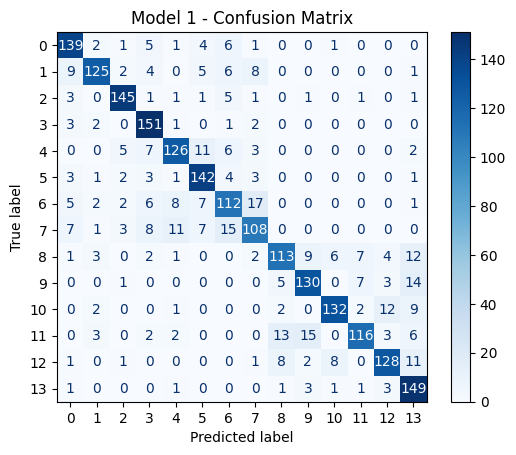

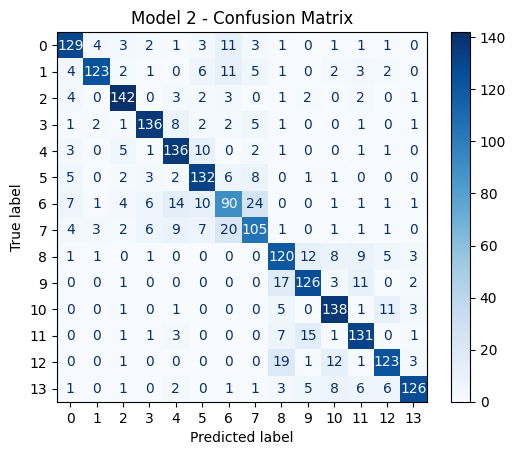

In [ ]:
evaluate_and_plot_confusion_matrix(model1, valloader, device, title="Model 1 - Confusion Matrix")
evaluate_and_plot_confusion_matrix(model2, valloader, device, title="Model 2 - Confusion Matrix")

In [ ]:
from sklearn.metrics import precision_score, confusion_matrix


def evaluate_precision_per_class(model, dataloader, device, class_names=None):
    model.eval()
    model.to(device)

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    global_precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)


    per_class_stats = []
    for idx, row in enumerate(cm):
        correct = row[idx]
        total = row.sum()
        incorrect = total - correct
        class_name = class_names[idx] if class_names else f"Class {idx}"
        per_class_stats.append({
            "class": class_name,
            "correct": correct,
            "incorrect": incorrect,
            "total": total
        })

    return global_precision, per_class_stats

In [ ]:
class_names = valset.classes

precision, stats = evaluate_precision_per_class(model1, valloader, device, class_names)

print(f"Global Precision (macro avg): {precision:.4f}\n")

for s in stats:
    print(f"{s['class']}: Correct = {s['correct']}, Incorrect = {s['incorrect']} (Total: {s['total']})")

Global Precision (macro avg): 0.8138

Baked Potato: Correct = 139, Incorrect = 21 (Total: 160)
Crispy Chicken: Correct = 125, Incorrect = 35 (Total: 160)
Donut: Correct = 145, Incorrect = 15 (Total: 160)
Fries: Correct = 151, Incorrect = 9 (Total: 160)
Hot Dog: Correct = 126, Incorrect = 34 (Total: 160)
Sandwich: Correct = 142, Incorrect = 18 (Total: 160)
Taco: Correct = 112, Incorrect = 48 (Total: 160)
Taquito: Correct = 108, Incorrect = 52 (Total: 160)
apple_pie: Correct = 113, Incorrect = 47 (Total: 160)
cheesecake: Correct = 130, Incorrect = 30 (Total: 160)
chicken_curry: Correct = 132, Incorrect = 28 (Total: 160)
ice_cream: Correct = 116, Incorrect = 44 (Total: 160)
omelette: Correct = 128, Incorrect = 32 (Total: 160)
sushi: Correct = 149, Incorrect = 11 (Total: 160)


In [ ]:
class_names = valset.classes

precision, stats = evaluate_precision_per_class(model2, valloader_aug, device, class_names)

print(f"Global Precision (macro avg): {precision:.4f}\n")

for s in stats:
    print(f"{s['class']}: Correct = {s['correct']}, Incorrect = {s['incorrect']} (Total: {s['total']})")

Global Precision (macro avg): 0.7866

Baked Potato: Correct = 129, Incorrect = 31 (Total: 160)
Crispy Chicken: Correct = 123, Incorrect = 37 (Total: 160)
Donut: Correct = 142, Incorrect = 18 (Total: 160)
Fries: Correct = 136, Incorrect = 24 (Total: 160)
Hot Dog: Correct = 136, Incorrect = 24 (Total: 160)
Sandwich: Correct = 132, Incorrect = 28 (Total: 160)
Taco: Correct = 90, Incorrect = 70 (Total: 160)
Taquito: Correct = 105, Incorrect = 55 (Total: 160)
apple_pie: Correct = 120, Incorrect = 40 (Total: 160)
cheesecake: Correct = 126, Incorrect = 34 (Total: 160)
chicken_curry: Correct = 138, Incorrect = 22 (Total: 160)
ice_cream: Correct = 131, Incorrect = 29 (Total: 160)
omelette: Correct = 123, Incorrect = 37 (Total: 160)
sushi: Correct = 126, Incorrect = 34 (Total: 160)


With data augmentation techniques, the model’s performance has improved, but only slightly. In some classes, it has even worsened. Let’s see how it performs on the test set


## Final test
Let's now evaluate the model's performance on the test set

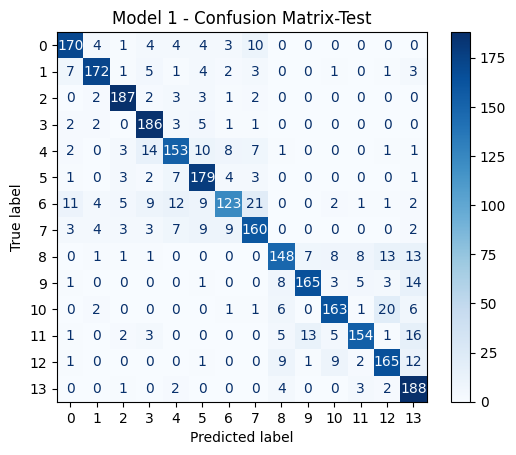

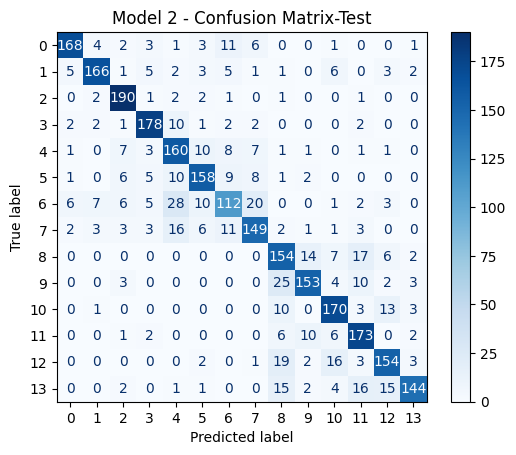

In [ ]:
evaluate_and_plot_confusion_matrix(model1, testloader, device, title="Model 1 - Confusion Matrix-Test")
evaluate_and_plot_confusion_matrix(model2, testloader_aug, device, title="Model 2 - Confusion Matrix-Test")

In [ ]:
class_names = testset.classes

precision, stats = evaluate_precision_per_class(model1, testloader, device, class_names)

print(f"Global Precision (macro avg): {precision:.4f}\n")

for s in stats:
    print(f"{s['class']}: Correct = {s['correct']}, Incorrect = {s['incorrect']} (Total: {s['total']})")

Global Precision (macro avg): 0.8293

Baked Potato: Correct = 170, Incorrect = 30 (Total: 200)
Crispy Chicken: Correct = 172, Incorrect = 28 (Total: 200)
Donut: Correct = 187, Incorrect = 13 (Total: 200)
Fries: Correct = 186, Incorrect = 14 (Total: 200)
Hot Dog: Correct = 153, Incorrect = 47 (Total: 200)
Sandwich: Correct = 179, Incorrect = 21 (Total: 200)
Taco: Correct = 123, Incorrect = 77 (Total: 200)
Taquito: Correct = 160, Incorrect = 40 (Total: 200)
apple_pie: Correct = 148, Incorrect = 52 (Total: 200)
cheesecake: Correct = 165, Incorrect = 35 (Total: 200)
chicken_curry: Correct = 163, Incorrect = 37 (Total: 200)
ice_cream: Correct = 154, Incorrect = 46 (Total: 200)
omelette: Correct = 165, Incorrect = 35 (Total: 200)
sushi: Correct = 188, Incorrect = 12 (Total: 200)


In [ ]:
class_names = testset.classes

precision, stats = evaluate_precision_per_class(model2,testloader_aug, device, class_names)

print(f"Global Precision (macro avg): {precision:.4f}\n")

for s in stats:
    print(f"{s['class']}: Correct = {s['correct']}, Incorrect = {s['incorrect']} (Total: {s['total']})")

Global Precision (macro avg): 0.8003

Baked Potato: Correct = 168, Incorrect = 32 (Total: 200)
Crispy Chicken: Correct = 166, Incorrect = 34 (Total: 200)
Donut: Correct = 190, Incorrect = 10 (Total: 200)
Fries: Correct = 178, Incorrect = 22 (Total: 200)
Hot Dog: Correct = 160, Incorrect = 40 (Total: 200)
Sandwich: Correct = 158, Incorrect = 42 (Total: 200)
Taco: Correct = 112, Incorrect = 88 (Total: 200)
Taquito: Correct = 149, Incorrect = 51 (Total: 200)
apple_pie: Correct = 154, Incorrect = 46 (Total: 200)
cheesecake: Correct = 153, Incorrect = 47 (Total: 200)
chicken_curry: Correct = 170, Incorrect = 30 (Total: 200)
ice_cream: Correct = 173, Incorrect = 27 (Total: 200)
omelette: Correct = 154, Incorrect = 46 (Total: 200)
sushi: Correct = 144, Incorrect = 56 (Total: 200)
